## Importações

In [158]:
import sys, os, importlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import lambda2nu, nu2lambda, c

In [159]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML('<center><h2>Texto Centralizado</h2></center>')

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [160]:
# lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
spec = importlib.util.spec_from_file_location("lumapi", lumapiFile)
lumapi = importlib.util.module_from_spec(spec)
sys.modules["lumapi"] = lumapi
spec.loader.exec_module(lumapi)
modeApi = lumapi.MODE(hide = False)

C:\Program Files\Lumerical\v221\api\python\lumapi.py:796: SyntaxWarning: invalid escape sequence '\s'
  message = re.sub('^(Error:)\s(prompt line)\s[0-9]+:', '', str(rvals[2])).strip()


In [161]:
um = 1e-6
nm = 1e-9

## Barra de progresso

In [162]:
from IPython.display import clear_output

def clear_console():
    # No loop, use:
    clear_output(wait=True)

def porcentagem(atual,total):
    clear_console()
    calculo = (atual)/(total) *100
    print(f"Porcentagem: {calculo:.2f} %")


## Descrições do Material

In [163]:
sub_material = 'SiO2 (Glass) - Palik'
gap = 200*nm

comprimento = 5*um
largura = 0.45*um
altura = 0.22*um

x_core = 0
y_core = 0.0*um
z_core = 0.0*um

core_material = 'Si (Silicon) - Palik'

radius = 10*um

## Criar o Material

In [164]:
modeApi.switchtolayout()

modeApi.deleteall()

modeApi.addrect()
modeApi.set('name', 'core_1')
modeApi.set('material', core_material)
modeApi.set("x", x_core)
modeApi.set("x span", comprimento)
modeApi.set("y", largura + gap)
modeApi.set("y span", largura)
modeApi.set("z", z_core)
modeApi.set("z span", altura)

modeApi.copy()
modeApi.set('name', 'core_2')
modeApi.set("x", x_core)
modeApi.set("x span", 2*radius + comprimento)
modeApi.set("y", y_core)

modeApi.addobject("90_bend_wg")
modeApi.set('name', 'bend1')
modeApi.set("first axis", 'z')
modeApi.set("base width", largura)
modeApi.set("base height", altura)
modeApi.set("radius", radius)
modeApi.set("rotation 1", -90)
modeApi.set("x", comprimento/2)
modeApi.set("y", largura + gap + radius)
modeApi.set("z", z_core)

modeApi.copy()
modeApi.set('name', 'bend2')
modeApi.set("rotation 1", -180)
modeApi.set("x", -comprimento/2)



## Descrições do solver

In [165]:
fde_solve_material = sub_material
x_fde = 0
y_fde = largura/2 + gap/2
z_fde = 0.0*um

x_span_fde = 0*um
y_span_fde = 5*um
z_span_fde = 5*um

mesh_cells = 200
wavelength = 1550*nm
startWvg = 1500*nm
stopWvg = 1600*nm
modes = 4

mesh_multiplier = 8

In [166]:
modeApi.switchtolayout()

modeApi.select("FDE")
modeApi.delete()

modeApi.select("mesh")
modeApi.delete()

modeApi.addfde()
modeApi.set("solver type", '2D X normal')
modeApi.set("background material", fde_solve_material)

modeApi.set("x", x_fde)
modeApi.set("y", y_fde)
modeApi.set("y span", y_span_fde)
modeApi.set("z", z_fde)
modeApi.set("z span", z_span_fde)

modeApi.set("define y mesh by", 'number of mesh cells')
modeApi.set("define z mesh by", 'number of mesh cells')
modeApi.set("mesh cells z", mesh_cells)
modeApi.set("mesh cells y", mesh_cells)

# Set solver properties
modeApi.set("wavelength", wavelength)

# Add ports
modeApi.set("number of trial modes", modes)


# Set simulation boundaries
modeApi.set('start waveLength', startWvg)
modeApi.set('stop waveLength', stopWvg)

modeApi.set('z min bc', "PML")
modeApi.set('z max bc', "PML")
modeApi.set('y min bc', "PML")
modeApi.set('y max bc', "PML")

modeApi.addmesh()
modeApi.set("set mesh multiplier", True)
modeApi.set("x", x_fde)
modeApi.set("x span", x_span_fde)
modeApi.set("y", y_fde)
modeApi.set("y span", y_span_fde)
modeApi.set("y mesh multiplier", mesh_multiplier)
modeApi.set("z", z_fde)
modeApi.set("z span", z_span_fde)
modeApi.set("y mesh multiplier", mesh_multiplier)

## Simulação

In [145]:
nmbOfModes = int(modeApi.findmodes())
print(modeApi.getresult("FDE::data::mode1"))

E
H
P
farfield
surface_normal
dimension
f
neff
ng
loss
TE polarization fraction
waveguide TE/TM fraction
mode effective area
x
y
z
Ex
Ey
Ez
Hx
Hy
Hz
Z0


## Perfis de campo

In [146]:
eField = np.squeeze(modeApi.getresult("FDE::data::mode1", "Ey"))
y_efielf = modeApi.getresult("FDE::data::mode1", "y") / um
z_efielf = modeApi.getresult("FDE::data::mode1", "z") / um
rfIndex = np.squeeze(modeApi.getdata("FDE::data::material", "index_y"))


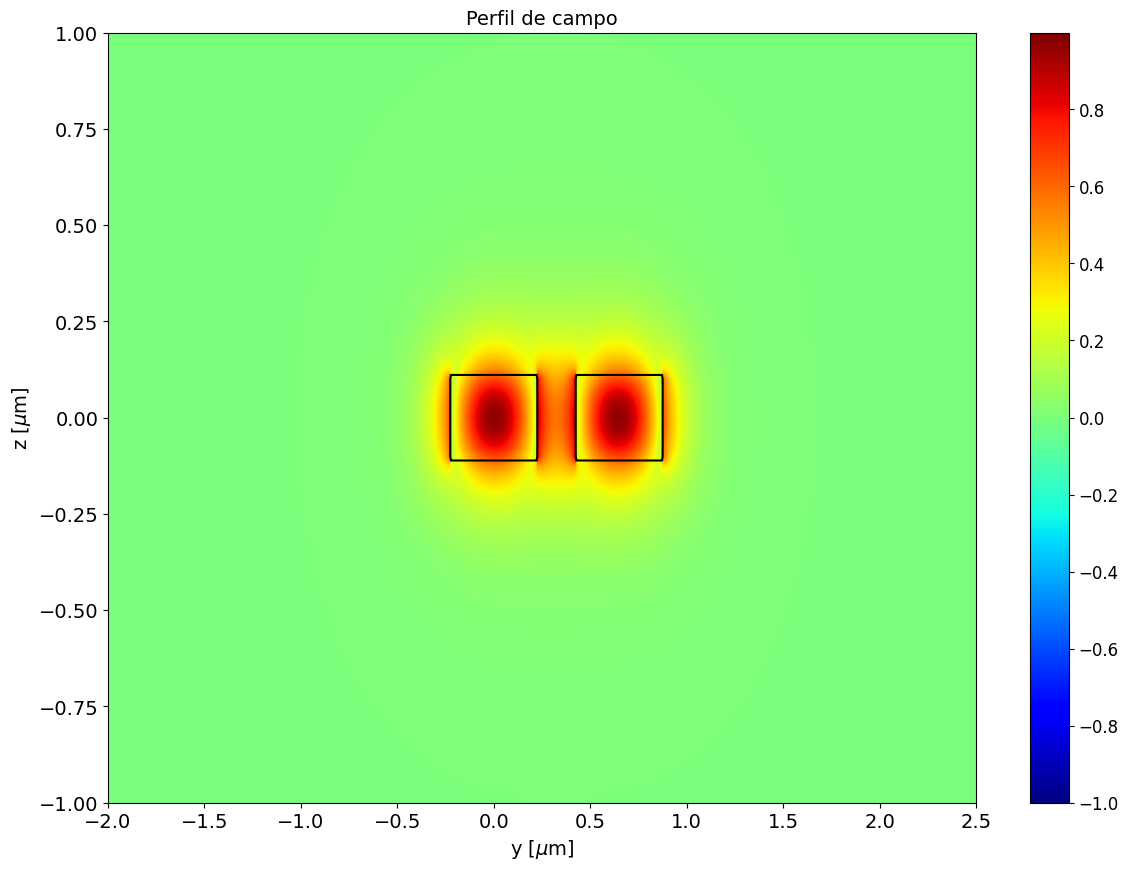

In [147]:
v = np.linspace(-1, 1, 2000, endpoint=True)

fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

y, z = np.meshgrid(y_efielf, z_efielf)

plt.contour(y, -z , np.rot90(rfIndex.real), 0, colors='k', origin='upper')
im = plt.contourf(y, -z , np.rot90(eField.real), v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)

plt.xlabel(r'y [$\mu$m]', fontsize = 14)
plt.ylabel(r'z [$\mu$m]', fontsize = 14)
plt.title('Perfil de campo', fontsize = 14)
colorbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', labelsize=14)


#plt.axis('equal')
plt.xlim([-2, 2.5])
plt.ylim([-1,1])
plt.savefig('MODO 1.png')
plt.show()

In [148]:
eField = np.squeeze(modeApi.getresult("FDE::data::mode2", "Ey"))
y_efielf = modeApi.getresult("FDE::data::mode2", "y") / um
z_efielf = modeApi.getresult("FDE::data::mode2", "z") / um

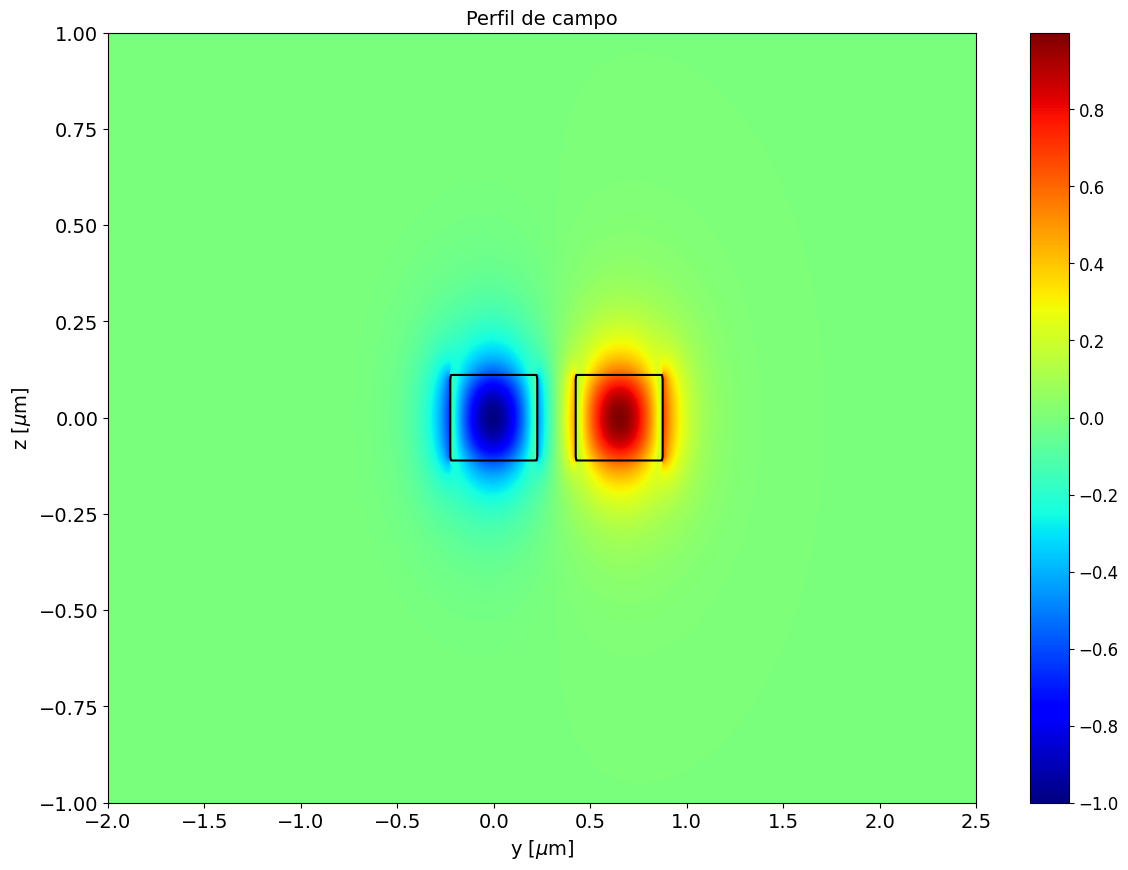

In [149]:
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111)

y, z = np.meshgrid(y_efielf, z_efielf)

plt.contour(y, -z , np.rot90(rfIndex.real), 0, colors='k', origin='upper')
im = plt.contourf(y, -z , np.rot90(eField.real), v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)

plt.xlabel(r'y [$\mu$m]', fontsize = 14)
plt.ylabel(r'z [$\mu$m]', fontsize = 14)
plt.title('Perfil de campo', fontsize = 14)
colorbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', labelsize=14)


#plt.axis('equal')
plt.xlim([-2, 2.5])
plt.ylim([-1,1])
plt.savefig('MODO 1.png')
plt.show()

## Neff

In [150]:
n1 = modeApi.getresult("FDE::data::mode1", "neff")
n2 = modeApi.getresult("FDE::data::mode2", "neff")

print(f"Índice 1 = {n1[0].real[0]:,.4f}, . Índice 2 = { n2[0].real[0]:,.4f}")

L_x = wavelength / (2 * np.abs(n1[0].real[0] - n2[0].real[0]))

print(f"Lx = {L_x*1e6:,.2f} um")

Índice 1 = 2.3755, . Índice 2 = 2.3438
Lx = 24.50 um


## Análise de convergência 

In [151]:
mesh = np.linspace(20, 200, 30)

mode1_neff = []
mode2_neff = []

modeApi.switchtolayout()
modeApi.select("mesh")
modeApi.set("y mesh multiplier", 6)
modeApi.set("z mesh multiplier", 6)

for i in range(len(mesh)):
    modeApi.switchtolayout()
    modeApi.select('FDE')
    modeApi.set("mesh cells y", mesh[i])
    modeApi.set("mesh cells z", mesh[i])
    
    porcentagem(i, len(mesh))
    modeApi.findmodes()
    porcentagem(i+1, len(mesh))
    
    mode1_neff.append(modeApi.getresult("FDE::data::mode1","neff")) 
    mode2_neff.append(modeApi.getresult("FDE::data::mode2","neff"))

Porcentagem: 100.00 %


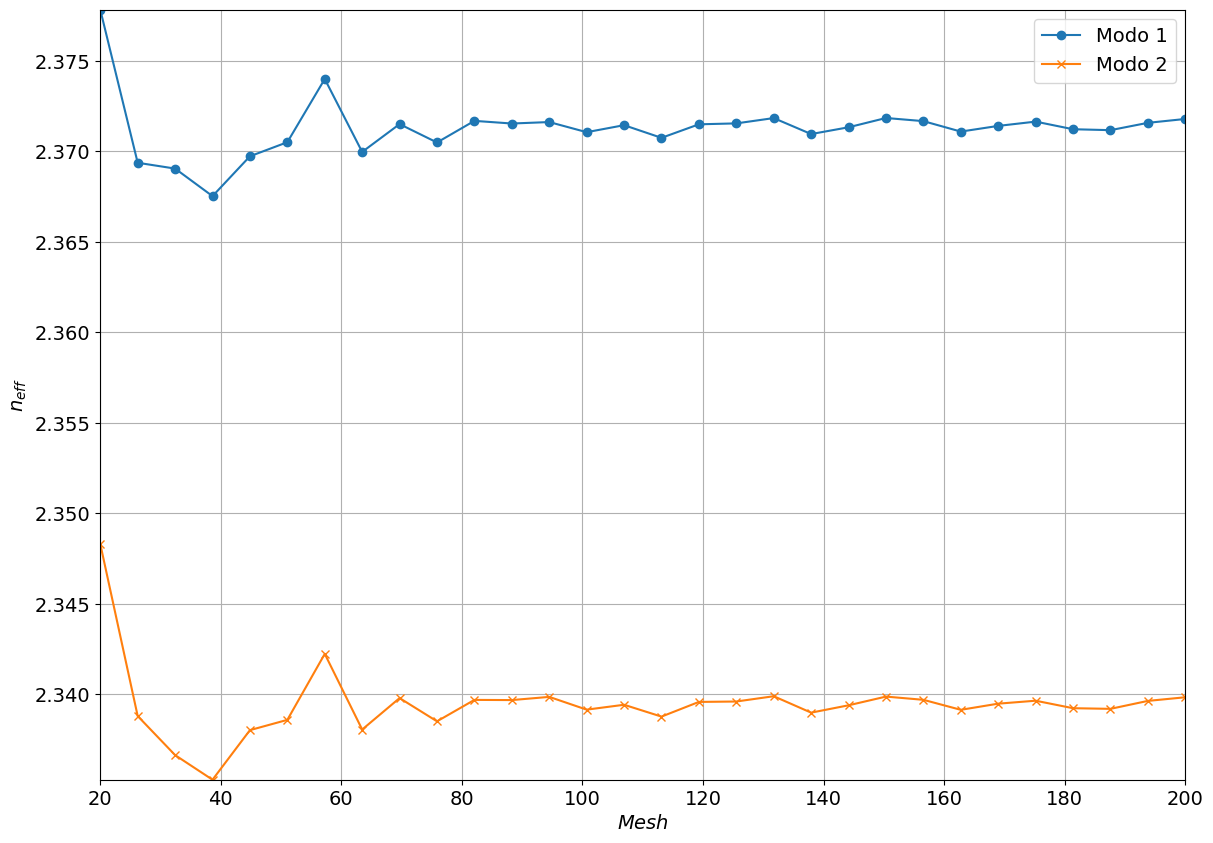

In [169]:
n_real_mode1 = np.array([a.real.item() for a in mode1_neff])
n_real_mode2 = np.array([a.real.item() for a in mode2_neff])
plt.figure(figsize=(14,10))

plt.plot(mesh,n_real_mode1, marker = 'o', label = 'Modo 1')
plt.plot(mesh,n_real_mode2, marker = 'x', label = 'Modo 2')
plt.xlabel('$Mesh$', fontsize = 14)
plt.ylabel('$n_{eff}$', fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

plt.xlim(min(mesh),max(mesh))
plt.ylim(min(n_real_mode2),max(n_real_mode1))

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig('ANALISE_DE_CONVERGENCIA.png')
plt.show()


## Comprimento de acoplamento em função do gap entre guias

Para esse caso basta fazer a atualização do $gap$ e obter $n_{eff}$ para cada um dos modos.

In [153]:
gap_change = np.linspace(0, 500*nm, 30)
n_gaps1 = []
n_gaps2 = []

modeApi.switchtolayout()
modeApi.select('FDE')
modeApi.set("mesh cells y", mesh_cells)
modeApi.set("mesh cells z", mesh_cells)

modeApi.select("mesh")
modeApi.set("y mesh multiplier", 4)
modeApi.set("z mesh multiplier", 4)

for i in range(len(gap_change)):

    # criar a estrutura
    modeApi.switchtolayout()

    modeApi.select("core_1")
    modeApi.delete()

    modeApi.select("core_2")
    modeApi.delete()

    modeApi.select("bend1")
    modeApi.delete()
    
    modeApi.select("bend2")
    modeApi.delete()

    modeApi.addrect()
    modeApi.set('name', 'core_1')
    modeApi.set('material', core_material)
    modeApi.set("x", x_core)
    modeApi.set("x span", comprimento)
    modeApi.set("y", largura + gap_change[i])
    modeApi.set("y span", largura)
    modeApi.set("z", z_core)
    modeApi.set("z span", altura)

    modeApi.copy()
    modeApi.set('name', 'core_2')
    modeApi.set("x", x_core)
    modeApi.set("x span", 2*radius + comprimento)
    modeApi.set("y", y_core)

    modeApi.addobject("90_bend_wg")
    modeApi.set('name', 'bend1')
    modeApi.set("first axis", 'z')
    modeApi.set("base width", largura);
    modeApi.set("base height", altura);
    modeApi.set("radius", radius)
    modeApi.set("rotation 1", -90)
    modeApi.set("x", comprimento/2)
    modeApi.set("y", largura + gap_change[i] + radius)
    modeApi.set("z", z_core)

    modeApi.copy()
    modeApi.set('name', 'bend2')
    modeApi.set("rotation 1", -180)
    modeApi.set("x", -comprimento/2)
    
    porcentagem(i, len(mesh))
    modeApi.findmodes()
    porcentagem(i+1, len(mesh))
    n_gaps1.append(modeApi.getresult("FDE::data::mode1","neff"))
    n_gaps2.append(modeApi.getresult("FDE::data::mode2","neff"))

Porcentagem: 100.00 %


Com isso, $L_x = \frac{\lambda}{2\cdot \Delta n}$ \
Onde, $\Delta n = n1 - n2$

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_9368\767961590.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$L_{x}$ ($\mu$m)', fontsize = 14)


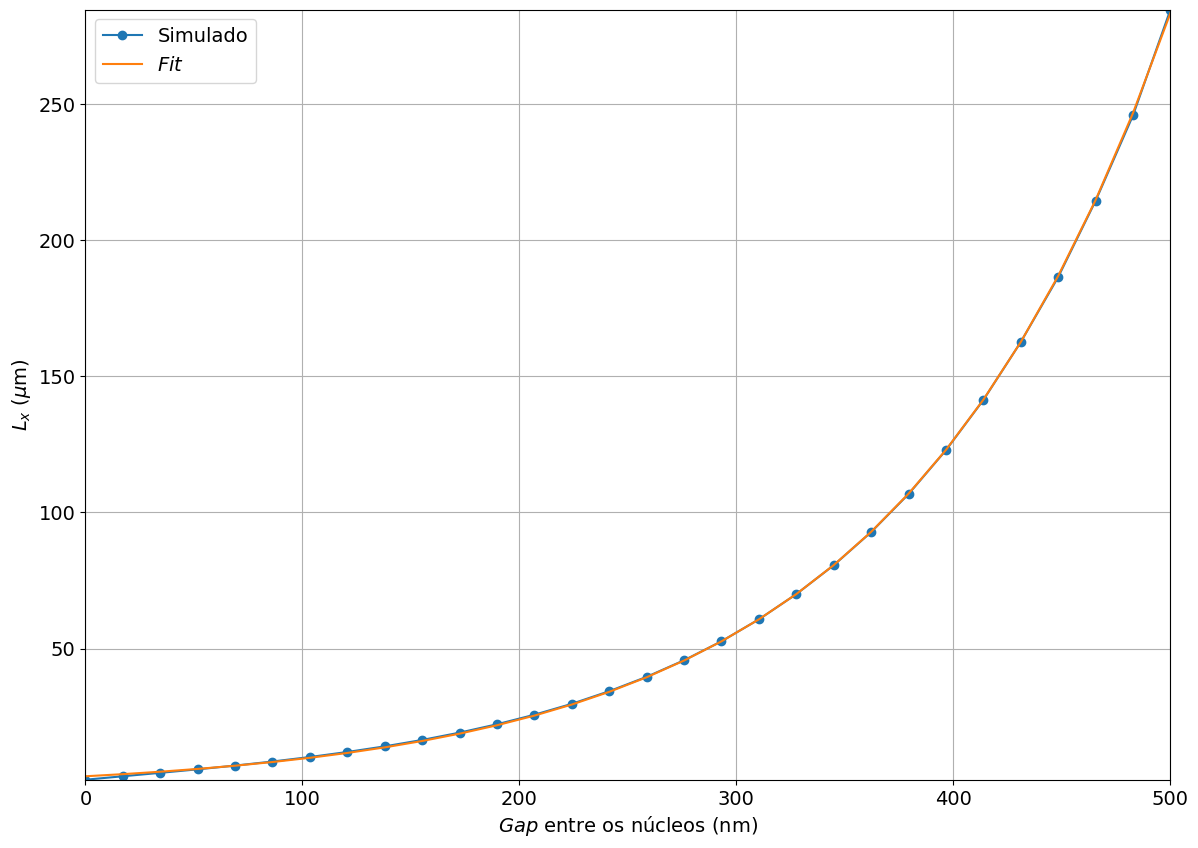

In [154]:
from scipy.optimize import curve_fit

n_real_gaps1 = np.array([a.real.item() for a in n_gaps1])
n_real_gaps2 = np.array([a.real.item() for a in n_gaps2])

L_x = (wavelength/(2*(n_real_gaps1 - n_real_gaps2)) )*1e6

#Realizar o fit
def funcao_exp(x, a, b, c):
    return c + a * np.exp(b * x)
parametros_otimos, covariancia = curve_fit(funcao_exp, gap_change, L_x)
# Pegar os parâmetros ótimos a e b
a_otimo, b_otimo, c_otimo = parametros_otimos
# Criar a curva ajustada usando os parâmetros ótimos
y_fit = funcao_exp(gap_change, a_otimo, b_otimo, c_otimo)


plt.figure(figsize=(14,10))

plt.plot(gap_change/nm,L_x, marker = 'o', label = 'Simulado')
plt.plot(gap_change/nm,y_fit, label='$Fit$')
plt.xlabel('$Gap$ entre os núcleos (nm)', fontsize = 14)
plt.ylabel('$L_{x}$ ($\mu$m)', fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

minimo = L_x[0] if L_x[0] <= y_fit[0] else y_fit[0]

plt.xlim(min(gap_change)/nm,max(gap_change)/nm)
plt.ylim(minimo,max(L_x))

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)
plt.savefig('GAP_ENTRE_NUCLEOS.png')

plt.show()


## Acoplamento de potência

$k^2 = sin^2(C\cdot L)$ é a fração de potência acoplada entre os guias \
$t^2 = cos^2(C\cdot L)$ é a fração de potência mantida no guia

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_9368\2219613462.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Comprimento do acoplamento ($\mu$m)",fontsize = 14)


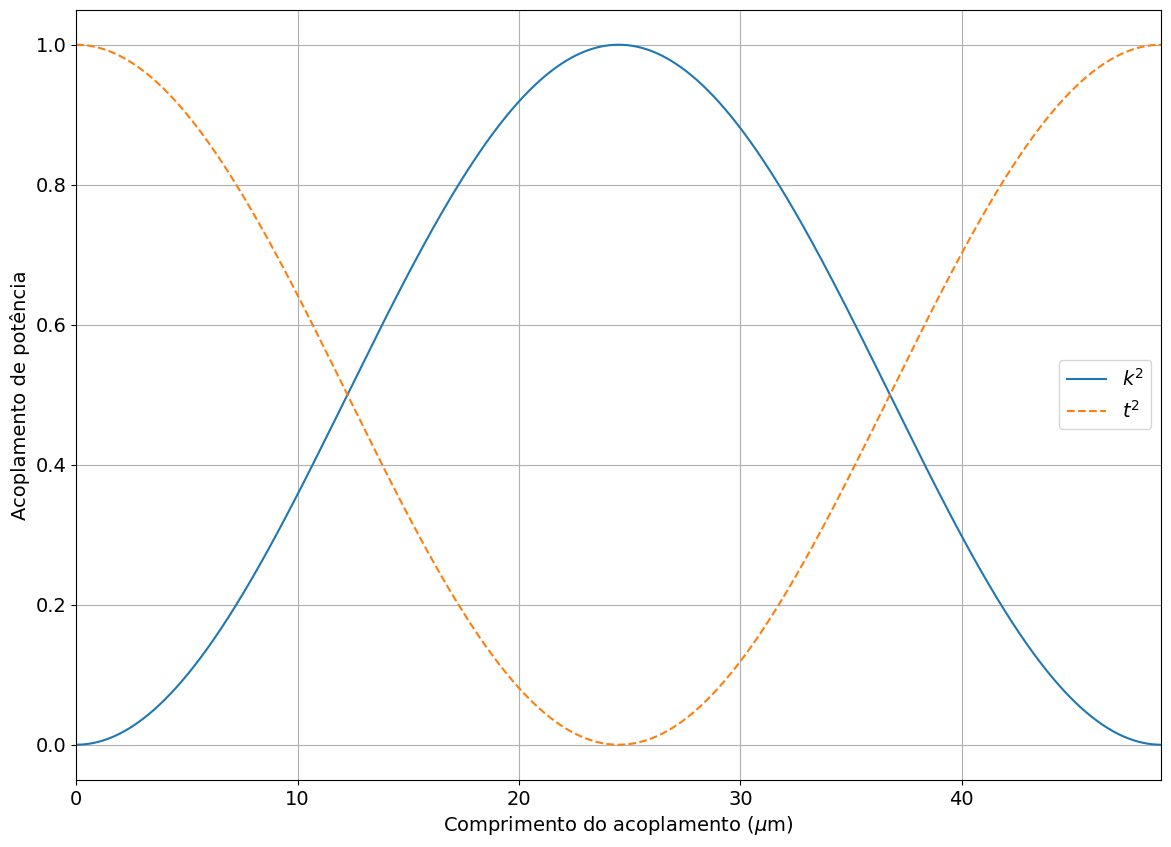

In [155]:
C = np.pi*(n1[0].real[0]-n2[0].real[0])/wavelength

L = np.linspace(0,np.pi/C,1000)/um

k = (np.sin(C*L))**2 # fracao de potencia acoplada
t = (np.cos(C*L))**2 # fração de potência mantida

plt.figure(figsize=(14,10))
plt.grid(True)
plt.plot(L,k, label = "$k^2$")
plt.plot(L,t, linestyle ="--", label = "$t^2$")
plt.xlim(0,np.pi/(C*um))
plt.xlabel("Comprimento do acoplamento ($\mu$m)",fontsize = 14)
plt.ylabel("Acoplamento de potência",fontsize = 14)
plt.tick_params(axis='both', labelsize=14)

plt.legend(loc = "best", fontsize = 14)
plt.savefig('ACOPLAMENTO_DE_POTENCIA.png')
plt.show()

## Comprimento do guia para diferentes proporções

In [156]:
#proporcao 50/50
func_diferenca = np.abs(k - 0.5) 

indices_ordenados = np.argsort(func_diferenca)
# Pegar os três menores índices
tres_menores_indices = indices_ordenados[:2] 
print("Proporção 50/50: ", L[tres_menores_indices])

#proporção 95/5
func_diferenca = np.abs(0.95 - k)  
indices_ordenados = np.argsort(func_diferenca)
# Pegar os três menores índices
tres_menores_indices = indices_ordenados[:2] 
print("Proporção 95/5: ", L[tres_menores_indices])

#proporção 99/1
func_diferenca = np.abs(0.99 - k)  
indices_ordenados = np.argsort(func_diferenca)
# Pegar os três menores índices
tres_menores_indices = indices_ordenados[:2] 
print("Proporção 99/1: ", L[tres_menores_indices])

#proporção 100/0
func_diferenca = np.abs(1 - k)  
indices_ordenados = np.argsort(func_diferenca)
# Pegar os três menores índices
tres_menores_indices = indices_ordenados[:2] 
print("Proporção 100/0: ", L[tres_menores_indices])


Proporção 50/50:  [12.262344   36.73798261]
Proporção 95/5:  [20.99313292 28.00719369]
Proporção 99/1:  [22.95510796 26.04521865]
Proporção 100/0:  [24.52468799 24.47563862]


In [157]:
modeApi.save("SIMULACAO_FDE.lms")